In [96]:
import numpy as np
import pandas as pd
import patsy as pt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import HTML
import copy
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
import graphviz
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn import ensemble

 

carseats_df = pd.read_csv('Carseats.csv')

# Check for missing values
assert carseats_df.isnull().sum().sum() == 0
# Drop unused index
carseats_df = carseats_df.drop('Unnamed: 0', axis=1)

# Create binary variable High 1 if Sales > 8
carseats_df['High'] = (carseats_df['Sales'] > 8).astype(np.float64)

# Create index for training set
np.random.seed(1)
train = np.random.random(len(carseats_df)) > 0.5

carseats_df.head()

#We now use the respective function to fit a classification tree in order to predict High using all variables but Sales.

#Please draw the tree and select the accuracy of the model for the training data.

# Use all features except response features
# No intercept
f = 'High ~ 0 + ' + ' + '.join(carseats_df.columns.drop(['Sales', 'High']))
y, X = pt.dmatrices(f, carseats_df)
y = y.flatten()

# Fit Sklearns tree classifier
clf = tree.DecisionTreeClassifier(max_depth=4).fit(X, y)

# Visualise the tree with GraphViz
dot_data = tree.export_graphviz(clf, out_file=None,
feature_names=X.design_info.column_names,
class_names=['Low', 'High'],
filled=True, rounded=True)
graph = graphviz.Source(dot_data)
#display(HTML(graph._repr_svg_()))

clf.score(X, y)

0.84

In [85]:
print(X[train].shape)
print(X[train == False].shape)

(216, 12)
(184, 12)


In [25]:
confusion_matrix(y, clf.predict(X))

array([[220,  16],
       [ 48, 116]])

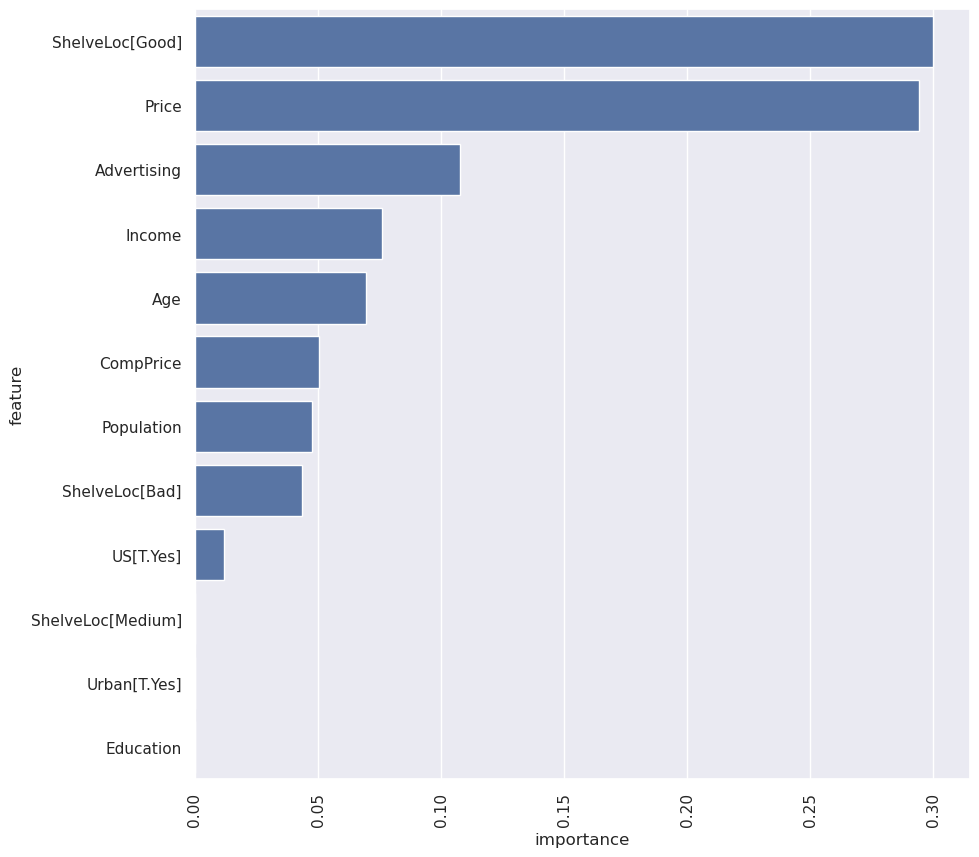

In [26]:
# Plot feature by importance in this model

plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance': clf.feature_importances_})

plt.figure(figsize=(10,10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False),
color='b')
plt.xticks(rotation=90);

In [27]:
# Fit Sklearn's tree classifier
clf = tree.DecisionTreeClassifier(max_depth=5).fit(X[train], y[train])

# Get confusion matrix for test set
y_hat = clf.predict(X[~train])
display(confusion_matrix(y[~train], y_hat))

# Get proportion of correct classifications on test set
print('Test accuracy: {}'.format(np.around(clf.score(X[~train], y[~train]), 4)))

array([[93, 16],
       [35, 40]])

Test accuracy: 0.7228


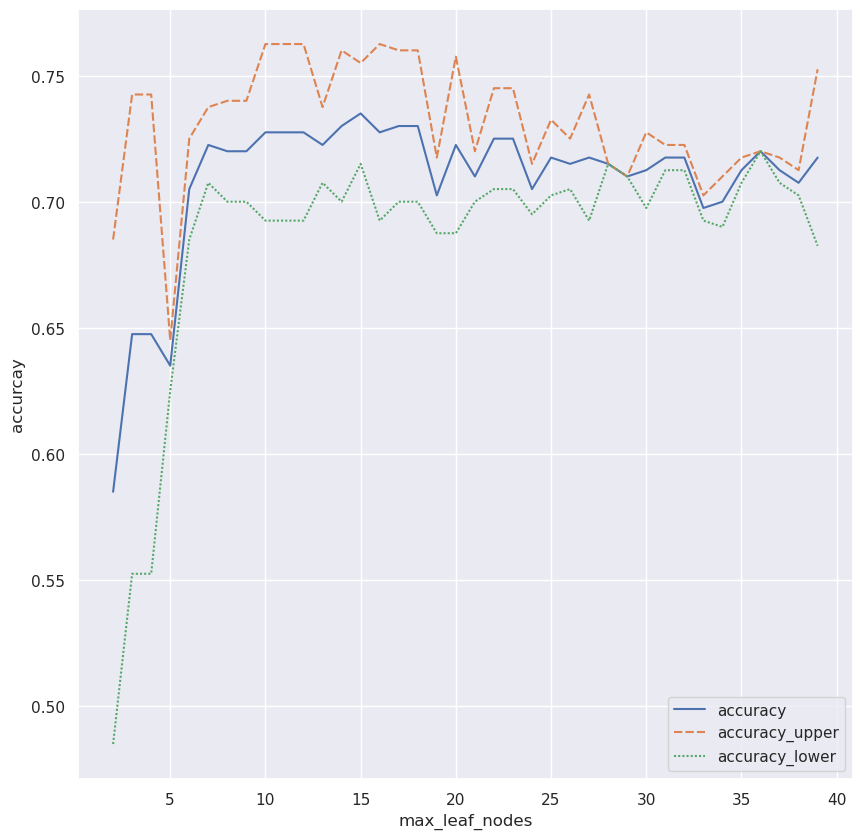

In [28]:
tuning_param = 'max_leaf_nodes'
columns=[tuning_param, 'accuracy', 'accuracy_upper', 'accuracy_lower']

results = []
for m in np.arange(2, 40):
    clf = tree.DecisionTreeClassifier(carseats_df.shape
X.shapemax_leaf_nodes=m)
    scores = cross_val_score(clf, X, y, cv=2)
    #rmses = np.sqrt(np.absolute(scores))
    rmse = np.mean(scores)
    conf_int = np.std(scores) *2
    results += [[m, rmse, rmse+conf_int, rmse-conf_int]]

# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('accurcay');

In [59]:
cs_df = pd.read_csv('/home/cabito/Documents/trabajos-Estadistica/Carseats.csv')
cs_df = pd.get_dummies(cs_df)
#carseats_df.head()
cs_df.columns
X2 = cs_df[['CompPrice', 'Income', 'Advertising',
       'Population', 'Price', 'Age', 'Education', 'ShelveLoc_Bad',
       'ShelveLoc_Good', 'ShelveLoc_Medium', 'Urban_No', 'Urban_Yes', 'US_No',
       'US_Yes']]
y2 = cs_df['Sales']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.33, random_state=1)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [91]:
np.random.seed(1)
arbolito = tree.DecisionTreeRegressor(max_depth=5)
arbolito.fit(X[train], carseats_df['Sales'][train])
y_pred = arbolito.predict(X[~train])
metrics.mean_squared_error(carseats_df['Sales'][~train], y_pred)

5.140142395079179

In [100]:
np.random.seed(1)
arbolito = tree.DecisionTreeRegressor(max_depth=5)
arbolito.fit(X[train], carseats_df['Sales'][train])
y_pred = arbolito.predict(X[~train])
metrics.mean_squared_error(carseats_df['Sales'][~train], y_pred)

5.140142395079179

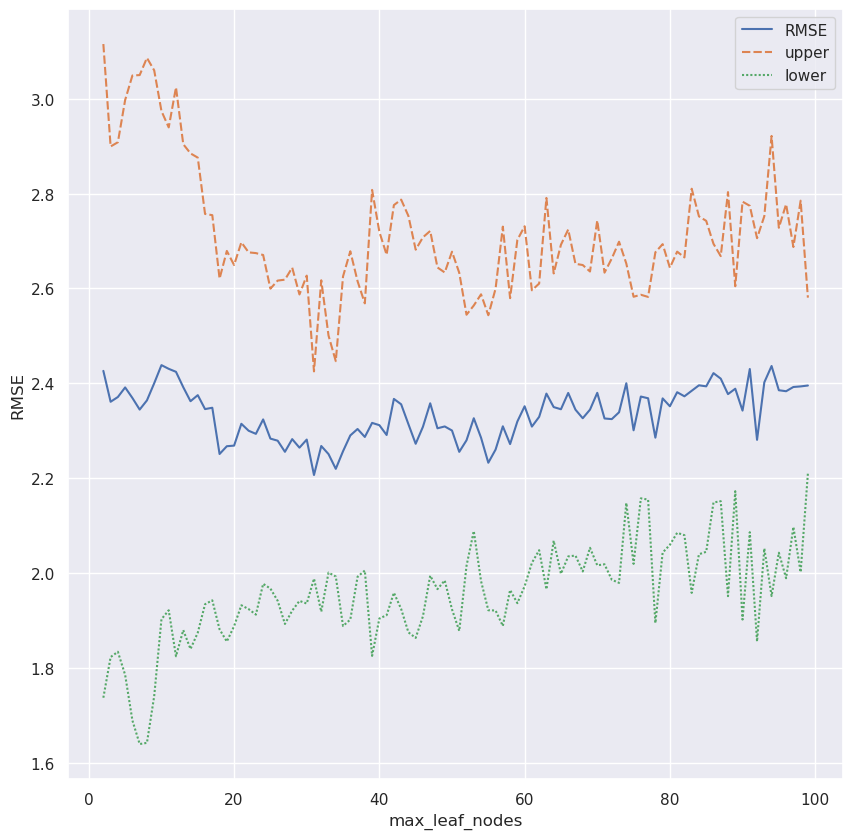

,RMSE,upper,lower
max_leaf_nodes,,,
31.0,2.206705,2.425195,1.988214


Test MSE : 4.661
Test RMSE: 2.159


In [102]:
np.random.seed(0)

cv_folds = 10
tuning_param = 'max_leaf_nodes'
columns=[tuning_param, 'RMSE', 'upper', 'lower']
y = carseats_df['Sales']
results = []
for m in np.arange(2, 100):
    regr = tree.DecisionTreeRegressor(max_leaf_nodes=m)
    scores = cross_val_score(regr, X[train], y[train], cv=cv_folds,scoring='neg_mean_squared_error')
    rmses = np.sqrt(np.absolute(scores))
    rmse = np.mean(rmses)
    conf_int = np.std(rmses) *2
    results += [[m, rmse, rmse+conf_int, rmse-conf_int]]
# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('RMSE')
plt.show();
# Show chosen model
chosen = plot_df[plot_df['RMSE'] == plot_df['RMSE'].min()]
display(chosen)
# Use chosen model for test prediction
regr = tree.DecisionTreeRegressor(max_leaf_nodes=int(chosen.index[0])).fit(X[train], y[train])
y_hat = regr.predict(X[~train])
mse = metrics.mean_squared_error(y[~train], y_hat)
# Get proportion of correct classifications on test set
print('Test MSE : {}'.format(np.around(mse, 3)))
print('Test RMSE: {}'.format(np.around(np.sqrt(mse), 3)))

In [106]:
print(X[train])

[[  0.   1.   0. ...  83.  65.  10.]
 [  0.   0.   1. ... 124.  76.  17.]
 [  0.   1.   0. ...  94.  50.  13.]
 ...
 [  0.   0.   1. ... 159.  40.  18.]
 [  1.   0.   0. ...  95.  50.  12.]
 [  0.   1.   0. ... 120.  49.  16.]]


In [109]:
np.random.seed(0)
arbolote = ensemble.RandomForestRegressor(n_estimators= 100, max_features = X.shape[1])
arbolote.fit(X[train], carseats_df['Sales'][train])
y_pred = arbolote.predict(X[~train])
metrics.mean_squared_error(carseats_df['Sales'][~train], y_pred)

2.6108939034782597

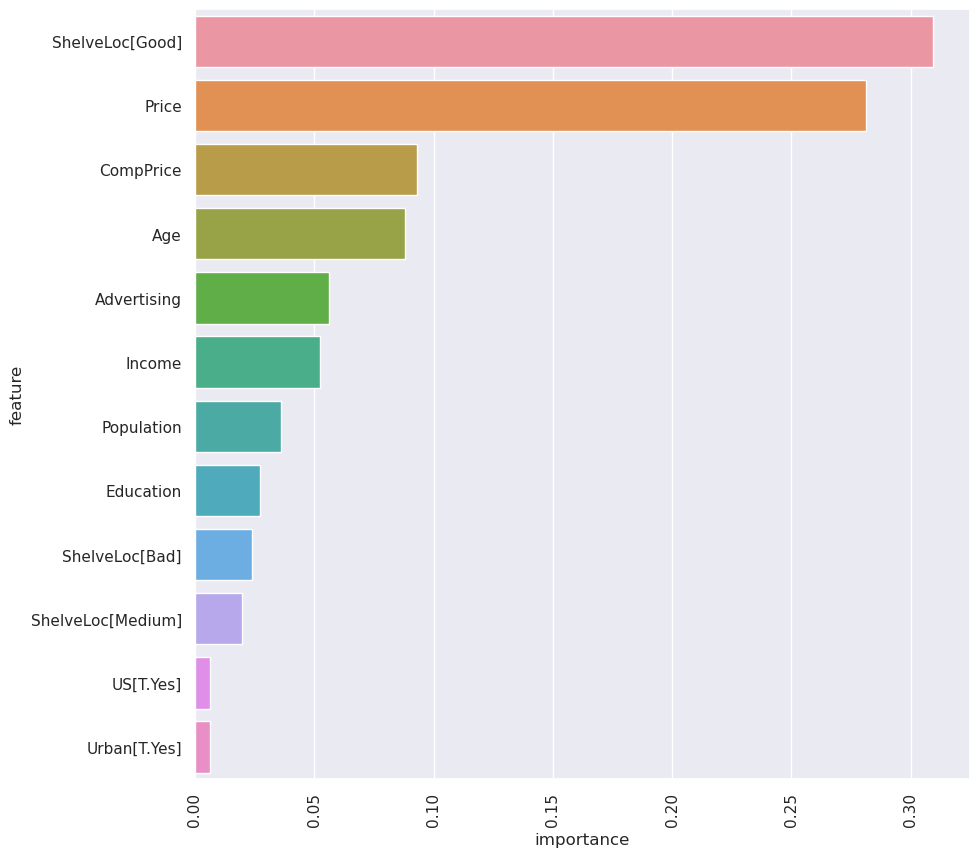

In [118]:
plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance' : arbolote.feature_importances_})
plt.figure(figsize = (10,10))
sns.barplot(x = 'importance', y = 'feature' , data = plot_df.sort_values('importance', ascending = False))
plt.xticks(rotation = 90)
plt.show();

In [125]:
import tqdm
np.random.seed(0)
xd = []
for i in tqdm.tqdm(range(1)):

    model = ensemble.RandomForestRegressor(n_estimators = 100, max_features = 7, random_state = 0)
    model.fit(X[train], carseats_df['Sales'][train])
    y_pred = model.predict(X[~train])
    xd.append(metrics.mean_squared_error(carseats_df['Sales'][~train], y_pred))
sum(xd)/len(xd)

100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


2.5659336164130413

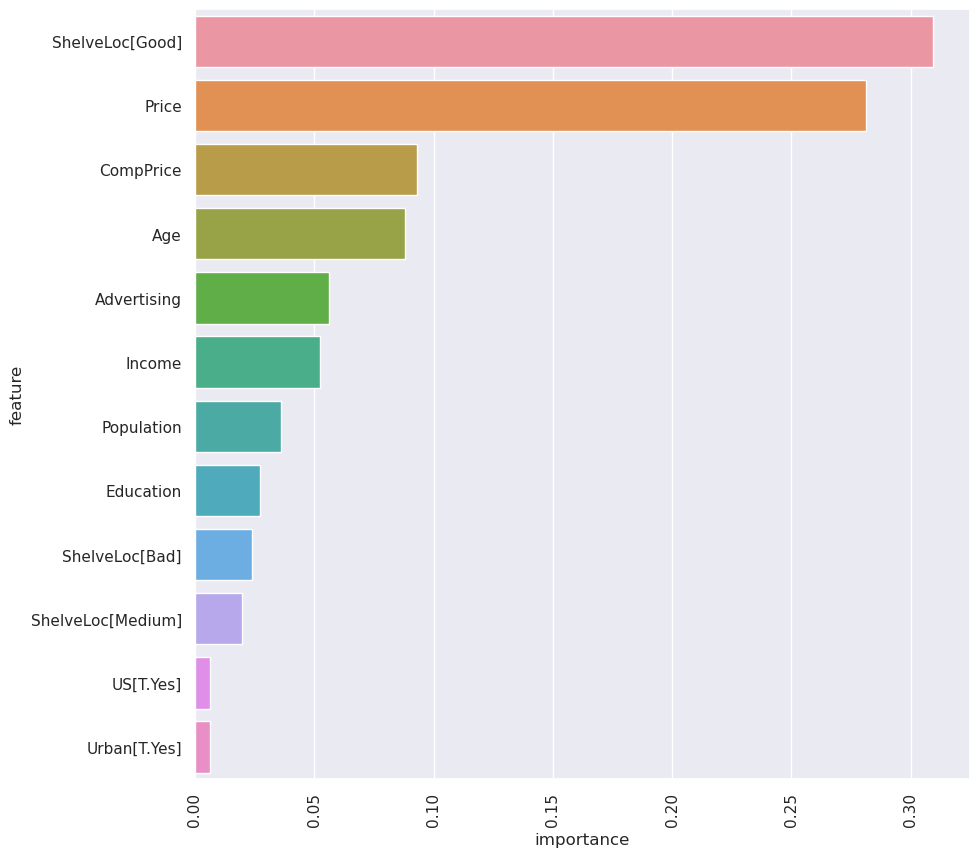

In [122]:
plot_df = pd.DataFrame({'feature': X.design_info.column_names, 'importance' : arbolote.feature_importances_})
plt.figure(figsize = (10,10))
sns.barplot(x = 'importance', y = 'feature' , data = plot_df.sort_values('importance', ascending = False))
plt.xticks(rotation = 90)
plt.show();

<AxesSubplot:xlabel='Split Variables', ylabel='MSE'>

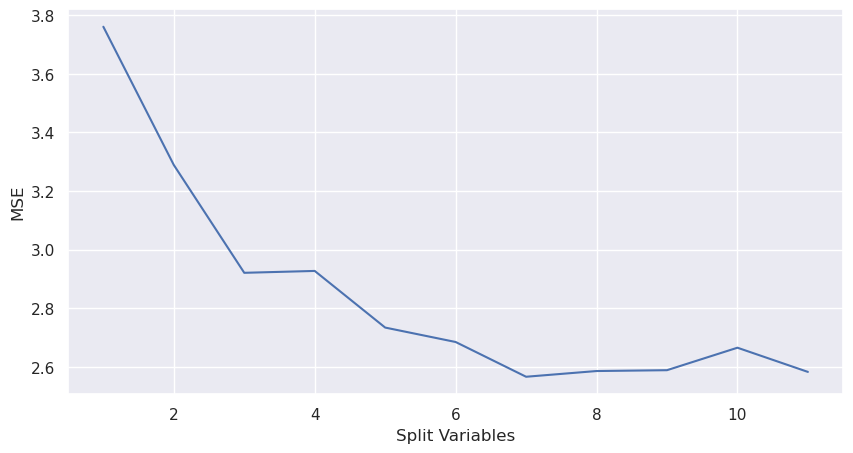

In [130]:
results = []
for max_features in np.arange(1, X.shape[1]):
    tree_count = 100

    regr = ensemble.RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
    regr.fit(X[train], y[train])
    y_hat = regr.predict(X[~train])

    mse = metrics.mean_squared_error(y[~train], y_hat)
    rmse = np.sqrt(mse)

    results += [[max_features, mse]]
plt.figure(figsize=(10,5))
sns.lineplot(x='Split Variables', y='MSE', data=pd.DataFrame(results, columns=['Split Variables', 'MSE']))